<a href="https://colab.research.google.com/github/sameer203/Tensorflow_/blob/main/11_NLP_fundamentals_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

--2021-11-03 18:07:28--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.213.128, 173.194.215.128, 108.177.12.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.213.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.005s  

2021-11-03 18:07:28 (117 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-11-03 18:07:28--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-11-03 18:07:28 (93.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys,unzip_data

In [4]:
unzip_data("nlp_getting_started.zip")

### Visualizing Test data
1. pandas
2. tensorflowload text

In [5]:
import pandas as pd

In [6]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
# Shuffle training data
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [8]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [9]:
train_df_shuffled.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [10]:
len(train_df), len(test_df)

(7613, 3263)

In [11]:
import random
random_index = random.randint(0, len(train_df)-5)
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real diaster)" if target > 0 else "(not real diaster)")
  print(f"Text:\n {text}\n")

Target: 1 (real diaster)
Text:
 #Kisii Police in Kisii hunt for students over failed arson plot: Police in Kisii hunt for students... http://t.co/5bdrFU1duo #CountyNews

Target: 1 (real diaster)
Text:
 Debris confirmed from MH370; relatives hope for discovery of crash site http://t.co/rLFtjmHHvT via @Reuters #Video

Target: 1 (real diaster)
Text:
 @HopefulBatgirl went down I was beaten and blown up. Then next thing I know Ra Al Ghul brought me back to life and I escaped and for a---

Target: 0 (not real diaster)
Text:
 @_charleyisqueen Yeah well maybe if the barber didn't cut my hair too short on top I wouldn't of gone through the egg trouble????

Target: 0 (not real diaster)
Text:
 lmfao fucking luis hhahaha im dead



In [12]:
from sklearn.model_selection import train_test_split

In [13]:
train_sentences, test_sentences, train_labels, test_labels = train_test_split(train_df_shuffled["text"].to_numpy(), 
                                                                              train_df_shuffled["target"].to_numpy(), 
                                                                              test_size=0.1, 
                                                                              random_state=42)

In [14]:
len(train_sentences), len(test_sentences)

(6851, 762)

In [15]:
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object), array([0, 

### Text Vectorization

In [16]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [17]:
# use the defaultTextVectorization parameters
text_vectorization = TextVectorization(max_tokens=None,
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode="int",
                                       output_sequence_length=None,
                                       pad_to_max_tokens=False)


In [18]:
# Find the average number of tokens in the training tweets
sum = 0
for i in train_sentences:
  sum = sum + len(i.split())
round(sum)
average = round(sum/len(train_sentences))
average

15

In [19]:
# Setup text vectorization variables
max_vocab_length = 10000
max_length = 15
text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                       output_sequence_length=max_length,
                                       output_mode="int")

In [20]:
# Fit the text vectorizer to the training data
text_vectorizer.adapt(train_sentences)

In [21]:
# Create a samplesentence and tokenize it
sample_sentence= "My name is sameer"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 13, 735,   9,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [22]:
# Vectorize a random sentence from training set
random_sentence = random.choice(train_sentences)

random_sentence, text_vectorizer([random_sentence])

("Bed time. Don't wake me up unless revolution or Armageddon start.",
 <tf.Tensor: shape=(1, 15), dtype=int64, numpy=
 array([[1040,   92,   63,  722,   31,   27, 1744, 3467,   53,  443,  667,
            0,    0,    0,    0]])>)

In [23]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
words_in_vocab[:5]

['', '[UNK]', 'the', 'a', 'in']

In [24]:
words_in_vocab[-5:]

['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']

In [25]:
from tensorflow.keras import layers

In [26]:
embedding = layers.Embedding(input_dim=max_vocab_length,
                             output_dim=128,
                             input_length=max_length)
embedding

In [27]:
# turn sentences into dense vector of fixed size
random_sentence = random.choice(train_sentences)

sample_embed = embedding(text_vectorizer([random_sentence]))

random_sentence, sample_embed

('A Marshall Plan for the United States by Dambisa Moyo via @ProSyn #oped http://t.co/l5g2zJ3kgG via @po_st',
 <tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
 array([[[-0.01454926,  0.01140416, -0.01728865, ...,  0.04098078,
          -0.02783403,  0.01925195],
         [-0.00187365, -0.02967125,  0.03648629, ...,  0.02890499,
          -0.01123529, -0.01390763],
         [-0.01550473, -0.0389138 , -0.0015182 , ...,  0.03874319,
           0.02909121, -0.02433392],
         ...,
         [ 0.00703744,  0.02962688, -0.01640959, ..., -0.021606  ,
           0.03665422,  0.02265802],
         [-0.02173947, -0.02741388,  0.00060564, ..., -0.04500641,
          -0.00673969,  0.01184937],
         [-0.04450415,  0.00111791,  0.02641435, ...,  0.02578033,
           0.00222499,  0.00209309]]], dtype=float32)>)

In [28]:
# checkout single tokens embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([-0.01454926,  0.01140416, -0.01728865, -0.00182513, -0.02159037,
        -0.04061365,  0.02038081, -0.03850944, -0.02819178,  0.03039095,
         0.00553349,  0.02625776, -0.02558987,  0.00440954, -0.02731069,
        -0.01962606, -0.01067413,  0.04282385, -0.00226905,  0.03698678,
        -0.0086954 , -0.02876586, -0.03444047, -0.03560166, -0.03105109,
         0.04616134,  0.03984911,  0.04592947, -0.00070952,  0.0287429 ,
        -0.02815927, -0.021808  ,  0.04326629,  0.00555191,  0.0067492 ,
         0.02769506,  0.02968856,  0.01361318, -0.02187083,  0.01932364,
         0.02755246, -0.00456329, -0.04296031,  0.03934611,  0.00284757,
        -0.03079791, -0.02787106,  0.03170713,  0.00297813, -0.04334944,
        -0.01285243,  0.03316975,  0.04485344, -0.03555629,  0.03221967,
         0.02670075, -0.03340458,  0.02778841, -0.03166421,  0.01907289,
         0.00862456,  0.02699398,  0.0225074 ,  0.02861989, -0.02845891,
  

### Model 0: Getting a baseline

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline


In [30]:
# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()),
                    ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [31]:
# Evaluate the baseline model
baseline_score = model_0.score(test_sentences, test_labels)
baseline_score*100

79.26509186351706

In [32]:
baseline_preds = model_0.predict(test_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [33]:
# Function to evaluate : Accuracy, precision, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_result(y_true, y_pred):
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_result = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_result

In [34]:
baseline_results = calculate_result(test_labels, baseline_preds)

baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

### Model 1: Asimple dense model

In [35]:
from helper_functions import create_tensorboard_callback

SAVE_DIR = "model_logs"

In [36]:
# Build model with functional API
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")

In [37]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
dense (Dense)                (None, 15, 1)             129       
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [38]:
# Compile the model
model_1.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_1.fit(x=train_sentences,
            y=train_labels,
            epochs=5,
            validation_data=(test_sentences, test_labels),
            callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                   experiment_name="model_1_dense")])

Saving TensorBoard log files to: model_logs/model_1_dense/20211103-180733
Epoch 1/5
215/215 [==============================] - 5s 19ms/step - loss: 0.6488 - accuracy: 0.6379 - val_loss: 0.6317 - val_accuracy: 0.6441
Epoch 2/5
215/215 [==============================] - 4s 16ms/step - loss: 0.5965 - accuracy: 0.6896 - val_loss: 0.6233 - val_accuracy: 0.6471
Epoch 3/5
215/215 [==============================] - 4s 17ms/step - loss: 0.5768 - accuracy: 0.6913 - val_loss: 0.6293 - val_accuracy: 0.6450
Epoch 4/5
215/215 [==============================] - 4s 17ms/step - loss: 0.5682 - accuracy: 0.6913 - val_loss: 0.6299 - val_accuracy: 0.6490
Epoch 5/5
215/215 [==============================] - 4s 17ms/step - loss: 0.5631 - accuracy: 0.6928 - val_loss: 0.6331 - val_accuracy: 0.6490


In [39]:
model_1.evaluate(test_sentences, test_labels)

24/24 [==============================] - 0s 2ms/step - loss: 0.6331 - accuracy: 0.6490


[0.6330755949020386, 0.6489938497543335]

In [40]:
model_1_pred_probs = model_1.predict(test_sentences)
model_1_pred_probs

array([[[0.4062367 ],
        [0.4062367 ],
        [0.4062367 ],
        ...,
        [0.0415158 ],
        [0.4062367 ],
        [0.3287416 ]],

       [[0.5814778 ],
        [0.35667494],
        [0.41905504],
        ...,
        [0.82355225],
        [0.4062367 ],
        [0.49794635]],

       [[0.9444991 ],
        [0.6093152 ],
        [0.48826262],
        ...,
        [0.96889484],
        [0.48826262],
        [0.48148924]],

       ...,

       [[0.5814778 ],
        [0.2891941 ],
        [0.35667494],
        ...,
        [0.82355225],
        [0.4062367 ],
        [0.3287416 ]],

       [[0.10451049],
        [0.64121246],
        [0.40351906],
        ...,
        [0.36119252],
        [0.34268808],
        [0.3355884 ]],

       [[0.20008707],
        [0.15580544],
        [0.44063148],
        ...,
        [0.4341326 ],
        [0.2458702 ],
        [0.6729148 ]]], dtype=float32)

In [41]:
model_1_pred_probs.shape

(762, 15, 1)

In [42]:
#adding Global average pooling layer to offset the error
# Build model with functional API
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")

# Compile the model
model_1.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_1.fit(x=train_sentences,
            y=train_labels,
            epochs=5,
            validation_data=(test_sentences, test_labels),
            callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                   experiment_name="model_1_dense")])

Saving TensorBoard log files to: model_logs/model_1_dense/20211103-180753
Epoch 1/5
215/215 [==============================] - 5s 18ms/step - loss: 0.5461 - accuracy: 0.7917 - val_loss: 0.5088 - val_accuracy: 0.7717
Epoch 2/5
215/215 [==============================] - 4s 16ms/step - loss: 0.3862 - accuracy: 0.8571 - val_loss: 0.4588 - val_accuracy: 0.7900
Epoch 3/5
215/215 [==============================] - 4s 16ms/step - loss: 0.3090 - accuracy: 0.8828 - val_loss: 0.4489 - val_accuracy: 0.7874
Epoch 4/5
215/215 [==============================] - 4s 17ms/step - loss: 0.2580 - accuracy: 0.9022 - val_loss: 0.4533 - val_accuracy: 0.7900
Epoch 5/5
215/215 [==============================] - 4s 16ms/step - loss: 0.2200 - accuracy: 0.9215 - val_loss: 0.4714 - val_accuracy: 0.7835


In [43]:
model_1.evaluate(test_sentences, test_labels)

24/24 [==============================] - 0s 2ms/step - loss: 0.4714 - accuracy: 0.7835


[0.47141310572624207, 0.7834645509719849]

In [44]:
model_1_pred_probs = model_1.predict(test_sentences)
model_1_pred_probs[:10]

array([[0.3096265 ],
       [0.7956712 ],
       [0.9975697 ],
       [0.16013613],
       [0.13336131],
       [0.949757  ],
       [0.8800517 ],
       [0.99674344],
       [0.97406876],
       [0.30304486]], dtype=float32)

In [45]:
# convert model prediction probability to label format
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds

<tf.Tensor: shape=(762,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0.,
       1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
       1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
       0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0

In [46]:
model_1_results = calculate_result(y_true=test_labels,
                                   y_pred = model_1_preds)
model_1_results

{'accuracy': 78.34645669291339,
 'f1': 0.7804929895574078,
 'precision': 0.7880043492637875,
 'recall': 0.7834645669291339}

In [47]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

In [48]:
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

### Visualizing learned embeddings

In [49]:
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [50]:
# Model summary
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [51]:
# Get the weight matrix of embedding layer
embed_weights = model_1.get_layer("embedding").get_weights()[0]
embed_weights, embed_weights[0].shape

(array([[-0.04285976,  0.07888448,  0.01720721, ..., -0.01203859,
         -0.03523231, -0.02570559],
        [-0.04613085, -0.01308475,  0.00588137, ..., -0.03995416,
         -0.01688099,  0.01509792],
        [-0.00226142,  0.03183166,  0.02954057, ...,  0.04495026,
         -0.05070239,  0.00404973],
        ...,
        [-0.01649725, -0.03285946,  0.03559586, ..., -0.03987722,
          0.04499492, -0.02901399],
        [ 0.08015774, -0.06725422, -0.04076953, ...,  0.09261865,
         -0.05864326, -0.03977483],
        [ 0.11145709, -0.1306635 , -0.09019736, ...,  0.14119834,
         -0.06773663, -0.08116058]], dtype=float32), (128,))

In [52]:
# Create embedding files
import io
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [53]:
# downloadfiles
try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Model 2: Recurrent Neural Network (RNN) LSTM

In [54]:
# LSTM model
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
#x = layers.LSTM(64, return_sequences=True)(x)
x = layers.LSTM(64)(x)
#x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_2 = tf.keras.Model(inputs, outputs, name="Model_2_LSTM")

In [55]:
model_2.summary()

Model: "Model_2_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                49408     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
_________________________________________________________________


In [56]:
# compile the model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [57]:
#Fit the model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(test_sentences, test_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_2_LSTM")])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20211103-180814
Epoch 1/5
215/215 [==============================] - 9s 32ms/step - loss: 0.2002 - accuracy: 0.9326 - val_loss: 0.6096 - val_accuracy: 0.7874
Epoch 2/5
215/215 [==============================] - 6s 28ms/step - loss: 0.1329 - accuracy: 0.9504 - val_loss: 0.5850 - val_accuracy: 0.7822
Epoch 3/5
215/215 [==============================] - 6s 29ms/step - loss: 0.1065 - accuracy: 0.9580 - val_loss: 0.7507 - val_accuracy: 0.7782
Epoch 4/5
215/215 [==============================] - 6s 29ms/step - loss: 0.0878 - accuracy: 0.9641 - val_loss: 0.9690 - val_accuracy: 0.7717
Epoch 5/5
215/215 [==============================] - 6s 28ms/step - loss: 0.0720 - accuracy: 0.9707 - val_loss: 0.9586 - val_accuracy: 0.7822


In [58]:
model_2_pred_probs = model_2.predict(test_sentences)
model_2_pred_probs[:10]

array([[2.5913984e-02],
       [5.4953700e-01],
       [9.9964243e-01],
       [5.4070562e-02],
       [2.7728081e-04],
       [9.9936402e-01],
       [1.9717431e-01],
       [9.9982619e-01],
       [9.9976987e-01],
       [3.1681997e-01]], dtype=float32)

In [59]:
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))

In [60]:
model_2_results = calculate_result(test_labels, model_2_preds)
model_2_results

{'accuracy': 78.21522309711287,
 'f1': 0.7801766074787211,
 'precision': 0.7840694582051416,
 'recall': 0.7821522309711286}

In [61]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

###Model 3: GRU

In [62]:
# Model 3 GRU :
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64)(x)
#x = layers.LSTM(64)(x)
#x = layers.GRU(64)(x)
#x = layers.Dense(64, activation="relu")(x)
#x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_3 = tf.keras.Model(inputs, outputs, name="Model_3_GRU")


In [63]:
model_3.summary()

Model: "Model_3_GRU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
gru (GRU)                    (None, 64)                37248     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_________________________________________________________________


In [64]:
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_3_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(test_sentences, test_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_3_GRU")])

Saving TensorBoard log files to: model_logs/model_3_GRU/20211103-180858
Epoch 1/5
215/215 [==============================] - 6s 29ms/step - loss: 0.0578 - accuracy: 0.9743 - val_loss: 1.0857 - val_accuracy: 0.7664
Epoch 2/5
215/215 [==============================] - 6s 28ms/step - loss: 0.0552 - accuracy: 0.9753 - val_loss: 1.2842 - val_accuracy: 0.7756
Epoch 3/5
215/215 [==============================] - 6s 29ms/step - loss: 0.0477 - accuracy: 0.9781 - val_loss: 1.3165 - val_accuracy: 0.7743
Epoch 4/5
215/215 [==============================] - 6s 28ms/step - loss: 0.0436 - accuracy: 0.9809 - val_loss: 1.3267 - val_accuracy: 0.7664
Epoch 5/5
215/215 [==============================] - 6s 28ms/step - loss: 0.0476 - accuracy: 0.9777 - val_loss: 1.4375 - val_accuracy: 0.7756


In [65]:
model_3_pred_probs = model_3.predict(test_sentences)
model_3_pred_probs[:10]

array([[0.5099109 ],
       [0.50744486],
       [0.50850356],
       [0.5134075 ],
       [0.52157456],
       [0.5142102 ],
       [0.5052482 ],
       [0.50300395],
       [0.50762296],
       [0.5135927 ]], dtype=float32)

In [66]:
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))

In [67]:
model_3_results = calculate_result(y_true=test_labels, 
                                   y_pred=model_3_preds)
model_3_results

{'accuracy': 46.194225721784775,
 'f1': 0.37583764254865537,
 'precision': 0.49068045598777765,
 'recall': 0.46194225721784776}

In [68]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

###Model 4: Bidirectional RNN

In [70]:
#Model 4
inputs = layers.Input(shape=(1,),dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.GRU(64))(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_4 = tf.keras.Model(inputs, outputs, name="model_4_bidirectional")


In [71]:
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
bidirectional (Bidirectional (None, 15, 128)           98816     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               74496     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 1,453,441
Trainable params: 1,453,441
Non-trainable params: 0
___________________________________

In [73]:
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_4_history = model_4.fit(train_sentences,
            train_labels,
            epochs=5,
            validation_data=(test_sentences, test_labels),
            callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                   "model_4_birectional")])

Saving TensorBoard log files to: model_logs/model_4_birectional/20211103-182236
Epoch 1/5
215/215 [==============================] - 21s 68ms/step - loss: 0.0726 - accuracy: 0.9696 - val_loss: 1.1800 - val_accuracy: 0.7638
Epoch 2/5
215/215 [==============================] - 12s 57ms/step - loss: 0.0469 - accuracy: 0.9758 - val_loss: 1.1353 - val_accuracy: 0.7612
Epoch 3/5
215/215 [==============================] - 12s 58ms/step - loss: 0.0432 - accuracy: 0.9793 - val_loss: 1.3335 - val_accuracy: 0.7703
Epoch 4/5
215/215 [==============================] - 13s 58ms/step - loss: 0.0408 - accuracy: 0.9793 - val_loss: 1.3073 - val_accuracy: 0.7651
Epoch 5/5
215/215 [==============================] - 12s 58ms/step - loss: 0.0386 - accuracy: 0.9819 - val_loss: 1.4897 - val_accuracy: 0.7756


In [74]:
model_4_pred_probs = model_4.predict(test_sentences)

In [75]:
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))

In [77]:
model_4_results = calculate_result(test_labels,
                                   model_4_preds)
model_4_results

{'accuracy': 77.55905511811024,
 'f1': 0.7738609431347062,
 'precision': 0.7767334207253159,
 'recall': 0.7755905511811023}

### Model 5: Conv1D

In [85]:
#testing conv1d
embedding_test = embedding(text_vectorizer(["my name is mohamed"]))
conv_1d = layers.Conv1D(filters=32,
                        kernel_size=5,
                        activation="relu",
                        padding="valid")
conv_1d_output = conv_1d(embedding_test)
max_pool = layers.GlobalAveragePooling1D()
max_pool_output = max_pool(conv_1d_output)

embedding_test.shape, conv_1d_output.shape, max_pool_output.shape


(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [93]:
#Model 5
inputs = layers.Input(shape=(1,),dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64, kernel_size=5, strides=1, activation="relu", padding="valid")(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

In [94]:
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 11, 64)            41024     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 1,321,089
Trainable params: 1,321,089
Non-trainable params: 0
__________________________________________

In [95]:
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_5_history = model_5.fit(train_sentences,
            train_labels,
            epochs=5,
            validation_data=(test_sentences, test_labels),
            callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                   "model_5_conv1D")])

Saving TensorBoard log files to: model_logs/model_5_conv1D/20211103-190153
Epoch 1/5
215/215 [==============================] - 5s 22ms/step - loss: 0.1018 - accuracy: 0.9666 - val_loss: 0.9109 - val_accuracy: 0.7638
Epoch 2/5
215/215 [==============================] - 4s 20ms/step - loss: 0.0622 - accuracy: 0.9771 - val_loss: 1.0809 - val_accuracy: 0.7585
Epoch 3/5
215/215 [==============================] - 4s 20ms/step - loss: 0.0557 - accuracy: 0.9762 - val_loss: 1.1816 - val_accuracy: 0.7598
Epoch 4/5
215/215 [==============================] - 4s 21ms/step - loss: 0.0500 - accuracy: 0.9783 - val_loss: 1.1689 - val_accuracy: 0.7520
Epoch 5/5
215/215 [==============================] - 4s 21ms/step - loss: 0.0451 - accuracy: 0.9809 - val_loss: 1.2002 - val_accuracy: 0.7507


In [96]:
model_5_pred_probs = model_5.predict(test_sentences)
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_results = calculate_result(test_labels,
                                   model_5_preds)
model_5_results

{'accuracy': 75.06561679790026,
 'f1': 0.7497154845080983,
 'precision': 0.7502819757880341,
 'recall': 0.7506561679790026}

### Model 6: Tf hub pretrained sentence Encoder

In [97]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embeddings = embed([
    "The quick brown fox jumps over the lazy dog.",
    "I am a sentence for which I would like to get its embedding"])

print(embeddings[0][:50])

tf.Tensor(
[-0.03133018 -0.06338634 -0.01607502 -0.01034897 -0.04650098  0.03723155
  0.0059158   0.07174399  0.01666447  0.06090763  0.06655259  0.02370509
  0.00057646  0.05684321  0.02416166 -0.00533629  0.04704771  0.01921575
  0.07682553  0.00566961 -0.07528222 -0.01713723 -0.07502711  0.07637347
 -0.05437962 -0.00138906 -0.01830186 -0.0467204  -0.04724139  0.02706781
  0.03233342  0.05537064  0.03370954 -0.01370661  0.00552705 -0.08226925
  0.01419507  0.06827915  0.01832052 -0.02147873  0.04149668 -0.02027402
 -0.00601059  0.02448243 -0.0884009  -0.02566539 -0.03832615 -0.05610627
  0.04681279  0.03203125], shape=(50,), dtype=float32)


In [98]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [99]:
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE")

In [105]:
#Model 6

model_6 = tf.keras.Sequential([
                               sentence_encoder_layer,
                               layers.Dense(64, activation="relu"),
                               layers.Dense(1, activation="sigmoid")
], name="model_6_USE")

In [106]:
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [107]:
model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE (KerasLayer)             (None, 512)               256797824 
_________________________________________________________________
dense_9 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 65        
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [108]:
model_6_history = model_6.fit(train_sentences,
            train_labels,
            epochs=5,
            validation_data=(test_sentences, test_labels),
            callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                   "model_6_USE")])

Saving TensorBoard log files to: model_logs/model_6_USE/20211103-193203
Epoch 1/5
215/215 [==============================] - 5s 17ms/step - loss: 0.5053 - accuracy: 0.7794 - val_loss: 0.4496 - val_accuracy: 0.8031
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.4125 - accuracy: 0.8167 - val_loss: 0.4356 - val_accuracy: 0.8123
Epoch 3/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3987 - accuracy: 0.8241 - val_loss: 0.4330 - val_accuracy: 0.8136
Epoch 4/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3897 - accuracy: 0.8257 - val_loss: 0.4323 - val_accuracy: 0.8110
Epoch 5/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3834 - accuracy: 0.8305 - val_loss: 0.4276 - val_accuracy: 0.8176


In [109]:
model_6_pred_probs = model_6.predict(test_sentences)
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_results = calculate_result(test_labels,
                                   model_6_preds)
model_6_results

{'accuracy': 81.75853018372703,
 'f1': 0.8158792847350168,
 'precision': 0.8206021490415145,
 'recall': 0.8175853018372703}

In [110]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

### Model 7: TF hub Pretrained model with 10% data

In [112]:
train_10_percent = train_df_shuffled[["text", "target"]].sample(frac=0.1, random_state=42)

train_sentences_10_percent = train_10_percent["text"].to_list()
train_labels_10_percent = train_10_percent["target"].to_list()

In [116]:
#Model 7

model_7 = tf.keras.Sequential([
                               sentence_encoder_layer,
                               layers.Dense(64, activation="relu"),
                               layers.Dense(1, activation="sigmoid")
], name="model_7_USE")

In [117]:
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [115]:
model_7.summary()

Model: "model_6_USE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE (KerasLayer)             (None, 512)               256797824 
_________________________________________________________________
dense_11 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 65        
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [118]:
model_7_history = model_7.fit(train_sentences_10_percent,
            train_labels_10_percent,
            epochs=5,
            validation_data=(test_sentences, test_labels),
            callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                   "model_7_USE")])

Saving TensorBoard log files to: model_logs/model_7_USE/20211103-194307
Epoch 1/5
24/24 [==============================] - 3s 70ms/step - loss: 0.6682 - accuracy: 0.7359 - val_loss: 0.6294 - val_accuracy: 0.8058
Epoch 2/5
24/24 [==============================] - 1s 25ms/step - loss: 0.5958 - accuracy: 0.7950 - val_loss: 0.5506 - val_accuracy: 0.8005
Epoch 3/5
24/24 [==============================] - 1s 25ms/step - loss: 0.5216 - accuracy: 0.7963 - val_loss: 0.4838 - val_accuracy: 0.8097
Epoch 4/5
24/24 [==============================] - 1s 25ms/step - loss: 0.4669 - accuracy: 0.8055 - val_loss: 0.4407 - val_accuracy: 0.8123
Epoch 5/5
24/24 [==============================] - 1s 26ms/step - loss: 0.4298 - accuracy: 0.8173 - val_loss: 0.4102 - val_accuracy: 0.8241


In [119]:
model_7_pred_probs = model_7.predict(test_sentences)
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_results = calculate_result(test_labels,
                                   model_7_preds)
model_7_results

{'accuracy': 82.41469816272966,
 'f1': 0.8238039995838143,
 'precision': 0.8240230848921042,
 'recall': 0.8241469816272966}

In [120]:
model_6_results

{'accuracy': 81.75853018372703,
 'f1': 0.8158792847350168,
 'precision': 0.8206021490415145,
 'recall': 0.8175853018372703}

### Data leakage

In [122]:
train_sentences[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

In [124]:
#train_10_percent = train_sentences[["text", "target"]].sample(frac=0.1, random_state=42)
train_10_percent_split = int(0.1*len(train_sentences))

train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]

In [125]:
#Model 8

model_8 = tf.keras.Sequential([
                               sentence_encoder_layer,
                               layers.Dense(64, activation="relu"),
                               layers.Dense(1, activation="sigmoid")
], name="model_8_USE")

model_8.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_8_history = model_8.fit(train_sentences_10_percent,
            train_labels_10_percent,
            epochs=5,
            validation_data=(test_sentences, test_labels),
            callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                   "model_8_USE")])

Saving TensorBoard log files to: model_logs/model_8_USE/20211103-195603
Epoch 1/5
22/22 [==============================] - 3s 80ms/step - loss: 0.6624 - accuracy: 0.7168 - val_loss: 0.6393 - val_accuracy: 0.7388
Epoch 2/5
22/22 [==============================] - 1s 26ms/step - loss: 0.5869 - accuracy: 0.8029 - val_loss: 0.5815 - val_accuracy: 0.7690
Epoch 3/5
22/22 [==============================] - 1s 24ms/step - loss: 0.5145 - accuracy: 0.8146 - val_loss: 0.5283 - val_accuracy: 0.7927
Epoch 4/5
22/22 [==============================] - 1s 26ms/step - loss: 0.4560 - accuracy: 0.8204 - val_loss: 0.5005 - val_accuracy: 0.7861
Epoch 5/5
22/22 [==============================] - 0s 22ms/step - loss: 0.4187 - accuracy: 0.8394 - val_loss: 0.4891 - val_accuracy: 0.7795


In [126]:
model_8_pred_probs = model_8.predict(test_sentences)
model_8_preds = tf.squeeze(tf.round(model_8_pred_probs))
model_8_results = calculate_result(test_labels,
                                   model_8_preds)
model_8_results

{'accuracy': 77.95275590551181,
 'f1': 0.7777699173240801,
 'precision': 0.7808713829501961,
 'recall': 0.7795275590551181}

### Comparing the model results

In [127]:
import pandas as pd

In [135]:
all_model_results = pd.DataFrame({"0_baseline": baseline_results,
                                  "1_simple_dense": model_1_results,
                                  "2_LSTM": model_2_results,
                                  "3_GRU": model_3_results,
                                  "4_bidirectional": model_4_results,
                                  "5_Conv1D": model_5_results,
                                  "6_tf_hub_USE": model_6_results,
                                  "7_tf_hub_USE_10": model_8_results})

all_models_results = all_model_results.transpose()
all_models_results

,accuracy,precision,recall,f1
0_baseline,79.265092,0.811139,0.792651,0.786219
1_simple_dense,78.346457,0.788004,0.783465,0.780493
2_LSTM,78.215223,0.784069,0.782152,0.780177
3_GRU,46.194226,0.490680,0.461942,0.375838
4_bidirectional,77.559055,0.776733,0.775591,0.773861
5_Conv1D,75.065617,0.750282,0.750656,0.749715
6_tf_hub_USE,81.758530,0.820602,0.817585,0.815879
7_tf_hub_USE_10,77.952756,0.780871,0.779528,0.777770


In [136]:
all_models_results["accuracy"] = all_models_results["accuracy"]/100

all_models_results

,accuracy,precision,recall,f1
0_baseline,0.792651,0.811139,0.792651,0.786219
1_simple_dense,0.783465,0.788004,0.783465,0.780493
2_LSTM,0.782152,0.784069,0.782152,0.780177
3_GRU,0.461942,0.490680,0.461942,0.375838
4_bidirectional,0.775591,0.776733,0.775591,0.773861
5_Conv1D,0.750656,0.750282,0.750656,0.749715
6_tf_hub_USE,0.817585,0.820602,0.817585,0.815879
7_tf_hub_USE_10,0.779528,0.780871,0.779528,0.777770


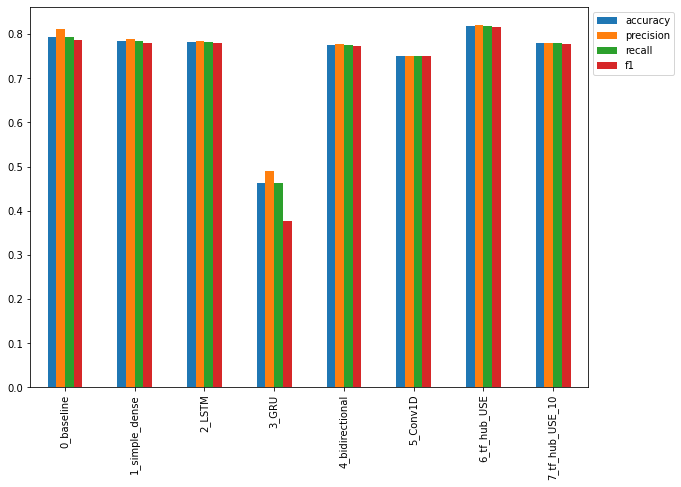

In [141]:
#all_models_results.plot(kind="bar", figsize(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

all_models_results.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1.0, 1.0));

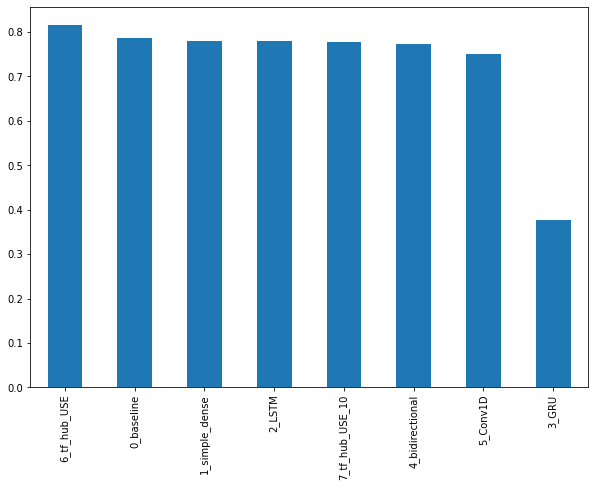

In [142]:
all_models_results.sort_values("f1",ascending=False)["f1"].plot(kind="bar", figsize=(10,7))